In [3]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
from network import DPATD

In [9]:
import matplotlib.pyplot as plt

In [2]:
# Redefine your model architecture (classes PatchEmbedding, ExplainableMultiHeadAttention, DualPhaseTransformerBlock, DPATD)

# Configuration (same as during training)
seq_len = 1323000  # Length of audio sequence
patch_size = 147
embed_dim = 64
num_heads = 8
ffn_dim = 256
num_layers = 4

In [39]:
# Initialize the model
model = DPATD(seq_len, patch_size, embed_dim, num_heads, ffn_dim, num_layers)

# Load the model weights
model.load_state_dict(torch.load('logs/experiment1/checkpoint/5.pkl')['model_state_dict'])
model.eval()  # Set the model to evaluation mode

DPATD(
  (embed): PatchEmbedding(
    (proj): Conv1d(1, 64, kernel_size=(147,), stride=(147,))
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x DualPhaseTransformerBlock(
      (mce_msa): ExplainableMultiHeadAttention(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (gru): GRU(64, 256, batch_first=True)
      (fc): Linear(in_features=256, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (deconv): ConvTranspose1d(64, 1, kernel_size=(147,), stride=(147,))
  (loss_fn): MSELoss()
)

In [6]:
def preprocess_audio(audio_path):
    audio, sr = librosa.load(audio_path, sr=44100)
    assert sr == 44100, "Sample rate must be 44100"
    audio = audio / np.max(np.abs(audio))
    if len(audio) < seq_len:
        audio = np.pad(audio, (0, seq_len - len(audio)))
    else:
        audio = audio[:seq_len]
    audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return audio_tensor

def postprocess_audio(denoised_audio, output_path):
    denoised_audio = denoised_audio / np.max(np.abs(denoised_audio))
    sf.write(output_path, denoised_audio, 44100)

In [41]:
noisy_audio_path = 'dns/training_set/noisy/fileid_0.wav'
output_path = 'pred.wav'

noisy_audio_tensor = preprocess_audio(noisy_audio_path)

with torch.no_grad():
    denoised_audio_tensor = model(noisy_audio_tensor)

denoised_audio = denoised_audio_tensor.squeeze().numpy()
postprocess_audio(denoised_audio, output_path)

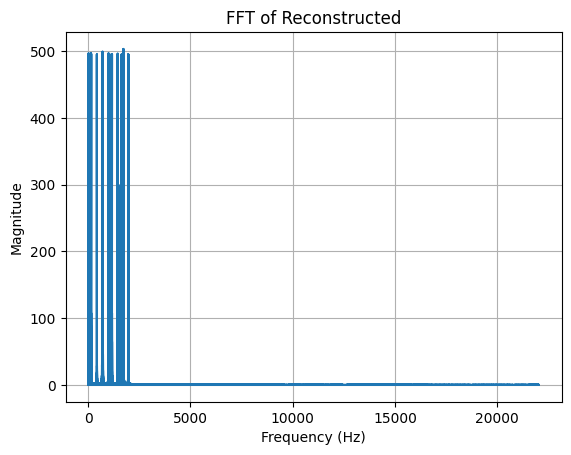

In [42]:
fs = 44100
fft = np.fft.fft(librosa.load('dns/training_set/clean/fileid_0.wav', sr=44100)[0])
freqs = np.fft.fftfreq(len(fft), 1/fs)
plt.figure()
L1 = abs(fft)
plt.plot(np.abs(freqs), L1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Reconstructed')
plt.grid(True)
plt.show()

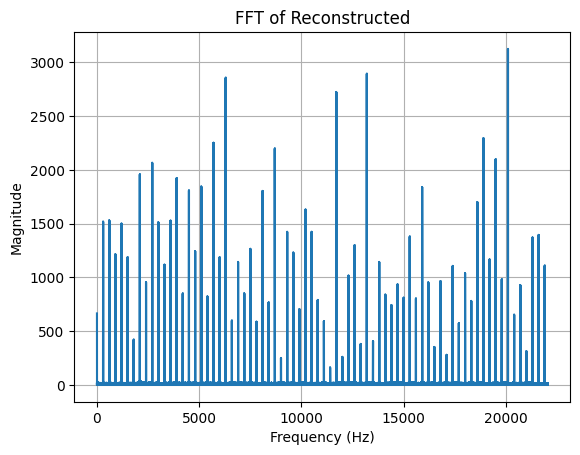

In [43]:
fs = 44100
fft = np.fft.fft(librosa.load('pred.wav', sr=44100)[0])
freqs = np.fft.fftfreq(len(fft), 1/fs)
plt.figure()
L1 = abs(fft)
plt.plot(np.abs(freqs), L1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Reconstructed')
plt.grid(True)
plt.show()